In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sys.path.append('../src')
from utils.load_bucket_prices import load_bucket_prices

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
tiingo_prices = load_bucket_prices('..', '2012-01-01', '2021-02-12')

Found existing price file. Reading...
Prices read from:  ../data/raw/prc_scorecard_single_ticker_2012-01-01_2021-02-12_Y.csv


In [3]:
tiingo_prices.index = tiingo_prices.index.tz_localize(None)

In [4]:
tickers = tiingo_prices.columns.get_level_values(1).unique().values

In [5]:
import requests
import json
import os

from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from pandas import json_normalize

api_key = os.getenv('FACTSET_API_KEY')
authorization = ('SCALABLE_MAG-1184867', api_key)

def make_fs_request(tickers, start, end):
    prices_endpoint = 'https://api.factset.com/content/factset-prices/v1/prices'
    prices_request = {
      "ids": list(tickers),
      "startDate": start,
      "endDate": end,
      "frequency": "D",
      "calendar": "FIVEDAY",
      "currency": "LOCAL",
      "adjust": "DIVADJ"
    }

    headers = {'Accept': 'application/json','Content-Type': 'application/json'}
    prices_post = json.dumps(prices_request)
    prices_response = requests.post(url = prices_endpoint, data=prices_post, auth = authorization, headers = headers, verify= False )
    print('HTTP Status: {}'.format(prices_response.status_code))

    return json.loads(prices_response.text)

In [6]:
prices_data = make_fs_request(tickers, '2012-01-01', '2021-02-12')

prices_df = json_normalize(prices_data['data'])
fs = prices_df.copy()
fs['date'] = pd.to_datetime(prices_df['date'])

fs = fs.rename(columns={
    'requestId': 'ticker',
    'price': 'adj_close',
    'priceOpen': 'adj_open',
    'priceHigh': 'adj_high',
    'priceLow': 'adj_low',
    'adjDate': 'adj_date'
})
fs = fs.drop('fsymId', axis=1)

fs = fs.set_index(['date', 'ticker'])
fs = fs.unstack(level=1)

fs.columns.names = ['attributes', 'symbols']
comp_columns = ['adj_close', 'adj_open', 'adj_high', 'adj_low', 'volume']

fs = fs[comp_columns]
fs = fs.loc[tiingo_prices.index]

HTTP Status: 200


In [95]:
diff = (tiingo_prices - fs) / fs
close_diff = diff['adj_close']
open_diff = diff['adj_open']

print('There are %d tickers with open diff greater than 1%%' % (
    open_diff.columns[(open_diff.max() > 0.01)].shape[0]))

big_diff_tickers = close_diff.columns[(close_diff.max() > 0.01)]
print('There are %d tickers with open diff greater than 1%%' % (
    big_diff_tickers.shape[0]))
big_diff_tickers

There are 45 tickers with open diff greater than 1%
There are 23 tickers with open diff greater than 1%


Index(['AMT', 'BIIB', 'CRM', 'CRNC', 'EBAY', 'FUBO', 'GS', 'GWRE', 'HPQ',
       'ISRG', 'NFLX', 'NLS', 'NOW', 'PANW', 'SPGI', 'SPWR', 'TMO', 'TMUS',
       'VG', 'VMW', 'WDAY', 'YELP', 'ZEN'],
      dtype='object', name='symbols')

<AxesSubplot:xlabel='symbols'>

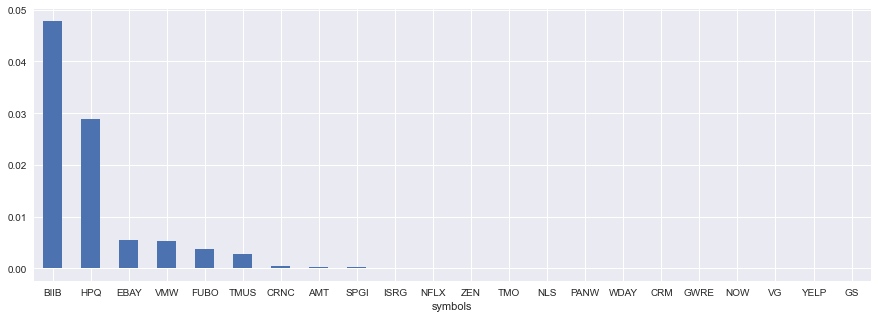

In [127]:
close_diff[big_diff_tickers].mean().sort_values(ascending=False).iloc[1:].plot.bar(rot=0)

In [110]:
mean_worse_than_100bp = diff.mean()['adj_close'] > 0.01

In [119]:
diff['adj_close'].columns[mean_worse_than_100bp]

Index(['BIIB', 'HPQ', 'SPWR'], dtype='object', name='symbols')

# CRNC

In [304]:
print(fs[('adj_close', 'CRNC')].dropna().iloc[:10])
print(tiingo_prices[('adj_close', 'CRNC')].dropna().iloc[:10])

date
2019-09-16    25.5000
2019-09-17    21.8666
2019-09-18    18.8000
2019-09-19    18.8288
2019-09-20    17.5000
2019-09-23    17.7344
2019-09-24    18.0000
2019-09-25    17.9500
2019-09-26    17.5000
2019-09-27    17.1250
Name: (adj_close, CRNC), dtype: float64
date
2019-09-16 00:00:00+00:00    25.5000
2019-09-17 00:00:00+00:00    21.8666
2019-09-18 00:00:00+00:00    21.8666
2019-09-19 00:00:00+00:00    18.8288
2019-09-20 00:00:00+00:00    17.5000
2019-09-23 00:00:00+00:00    17.7344
2019-09-24 00:00:00+00:00    18.0000
2019-09-25 00:00:00+00:00    17.9500
2019-09-26 00:00:00+00:00    17.5000
2019-09-27 00:00:00+00:00    17.5000
Name: (adj_close, CRNC), dtype: float64


In [306]:
print(fs[('volume', 'CRNC')].dropna().iloc[:10])
print(tiingo_prices[('volume', 'CRNC')].dropna().iloc[:10])

date
2019-09-16    0.308
2019-09-17    0.625
2019-09-18    0.000
2019-09-19    0.414
2019-09-20    2.462
2019-09-23    0.253
2019-09-24    2.500
2019-09-25    1.766
2019-09-26    0.397
2019-09-27    0.000
Name: (volume, CRNC), dtype: float64
date
2019-09-16 00:00:00+00:00     308.0
2019-09-17 00:00:00+00:00     625.0
2019-09-18 00:00:00+00:00      61.0
2019-09-19 00:00:00+00:00     414.0
2019-09-20 00:00:00+00:00    2462.0
2019-09-23 00:00:00+00:00     253.0
2019-09-24 00:00:00+00:00    2500.0
2019-09-25 00:00:00+00:00    1766.0
2019-09-26 00:00:00+00:00     397.0
2019-09-27 00:00:00+00:00     133.0
Name: (volume, CRNC), dtype: float64


Looks like there was either no trading or a very low number of trades on the 18th of Sept. FactSet reports 0 volume and a price drop of just under $3. Tiingo reports 61 trades and _no_ price change from the day before. Neither of these seem like consistent explanations.

Below: Yahoo finance snippet. Yahoo reports same prices as Tiingo and maybe 0 volume

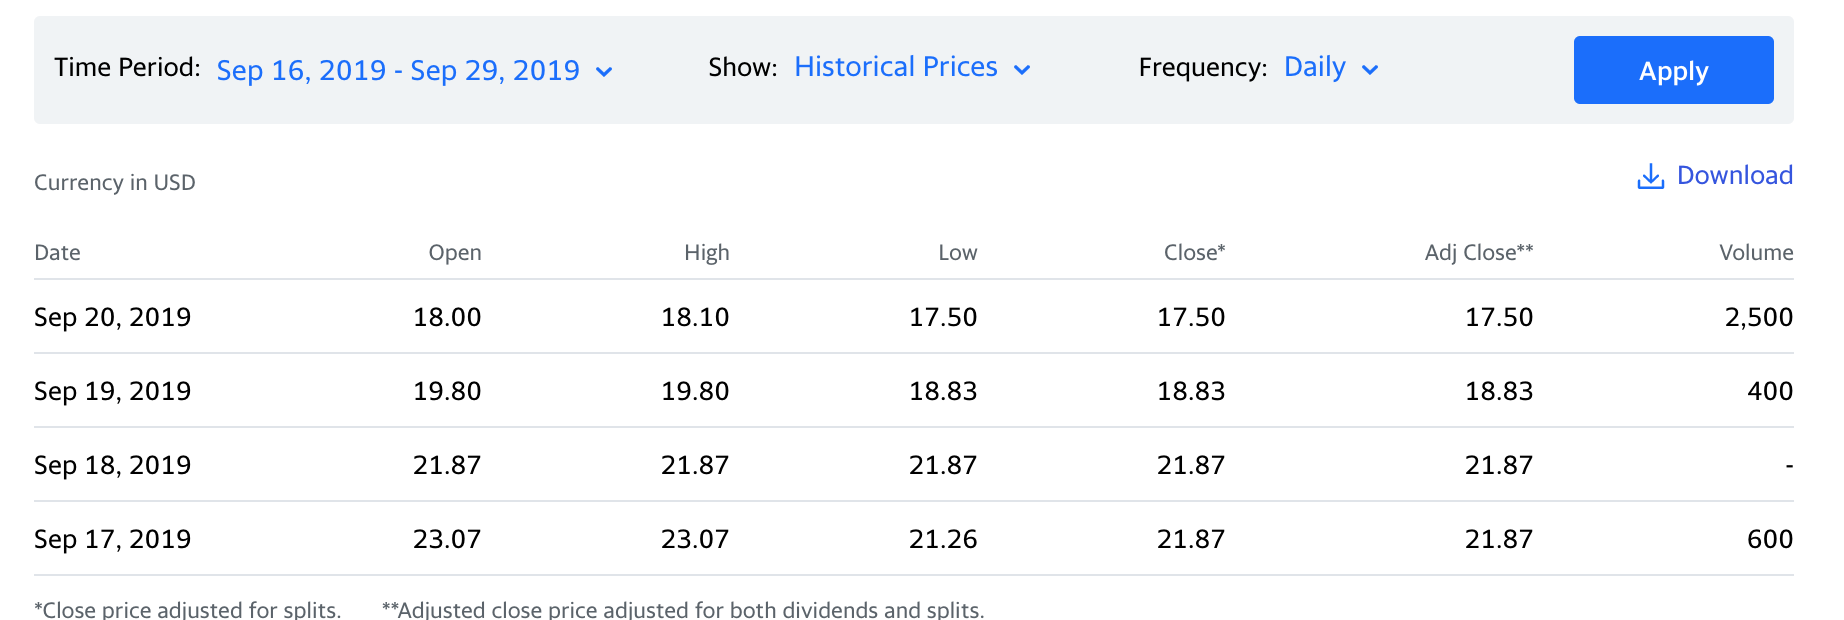

Below: report from FactSet dashboard. Shows the same info as the API

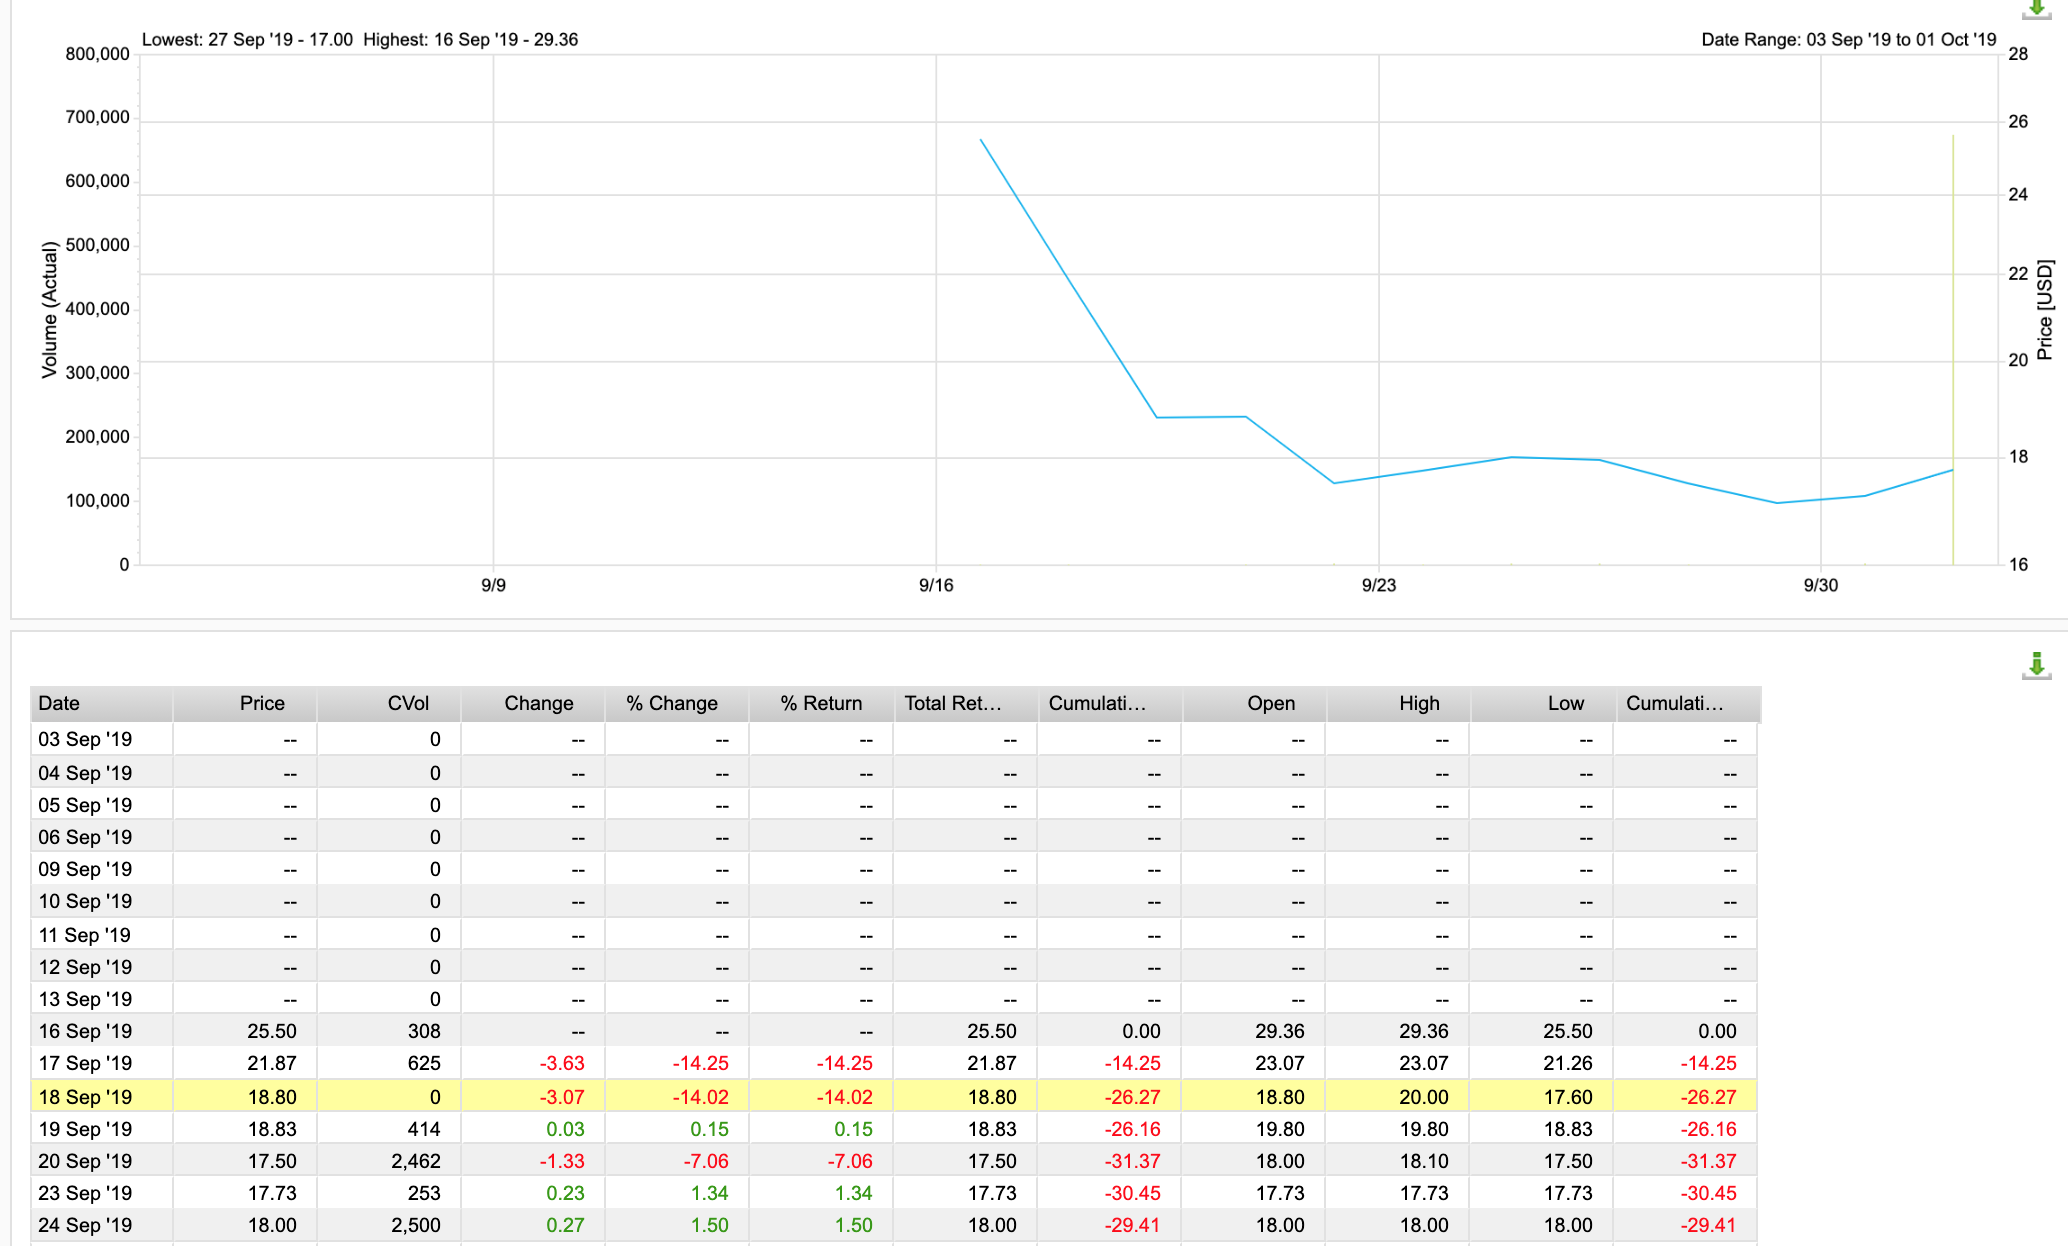

In [252]:
print(cp.loc['2014-08-10':'2014-08-25', ('volume', 'UPS')],
tiingo_prices.loc['2014-08-10':'2014-08-25', ('volume', 'UPS')])

date
2014-08-11    2971.266
2014-08-12    2356.830
2014-08-13    2930.398
2014-08-14    2277.701
2014-08-15    4873.999
2014-08-18    2913.197
2014-08-19    2640.127
2014-08-20    2629.775
2014-08-21    2411.447
2014-08-22    2569.699
2014-08-25    1785.533
Name: (volume, UPS), dtype: float64 date
2014-08-11 00:00:00+00:00    2971100.0
2014-08-12 00:00:00+00:00    2356800.0
2014-08-13 00:00:00+00:00    2930400.0
2014-08-14 00:00:00+00:00    2277700.0
2014-08-15 00:00:00+00:00    4873500.0
2014-08-18 00:00:00+00:00    2913200.0
2014-08-19 00:00:00+00:00    2640100.0
2014-08-20 00:00:00+00:00    2629700.0
2014-08-21 00:00:00+00:00    2411400.0
2014-08-22 00:00:00+00:00    2569600.0
2014-08-25 00:00:00+00:00    1785500.0
Name: (volume, UPS), dtype: float64


# HPQ

On Nov 1 2015, HPQ (Hewlett Packard) spun off HPE (HP Enterprise Co). I don't know how spin-offs are supposed to affect stock prices. Prices after that point are roughly the same between the two vendors, but before are different with tiingo higher than FS. [This article](https://www.forbes.com/sites/joecornell/2015/11/03/hp-hpq-completes-spin-off-of-enterprise-business/)  

MI disagrees with both.

In [310]:
tiingo_prices[('adj_close', 'HPQ')].loc['2015-10-20':'2015-11-10']

date
2015-10-20 00:00:00+00:00    11.672497
2015-10-21 00:00:00+00:00    11.537626
2015-10-22 00:00:00+00:00    11.758324
2015-10-23 00:00:00+00:00    11.864586
2015-10-26 00:00:00+00:00    11.472234
2015-10-27 00:00:00+00:00    11.218839
2015-10-28 00:00:00+00:00    11.435450
2015-10-29 00:00:00+00:00    11.186143
2015-10-30 00:00:00+00:00    11.018576
2015-11-02 00:00:00+00:00    11.668410
2015-11-03 00:00:00+00:00    12.056513
2015-11-04 00:00:00+00:00    11.929958
2015-11-05 00:00:00+00:00    11.854025
2015-11-06 00:00:00+00:00    11.820276
2015-11-09 00:00:00+00:00    11.702158
2015-11-10 00:00:00+00:00    11.913084
Name: (adj_close, HPQ), dtype: float64

In [311]:
fs[('adj_close', 'HPQ')].loc['2015-10-20':'2015-11-10']

date
2015-10-20    10.927942
2015-10-21    10.801678
2015-10-22    11.008300
2015-10-23    11.107779
2015-10-26    10.740453
2015-10-27    10.503224
2015-10-28    10.706017
2015-10-29    10.472614
2015-10-30    10.315736
2015-11-02    11.655768
2015-11-03    12.043452
2015-11-04    11.917036
2015-11-05    11.841182
2015-11-06    11.807471
2015-11-09    11.689482
2015-11-10    11.900178
Name: (adj_close, HPQ), dtype: float64

<AxesSubplot:xlabel='date'>

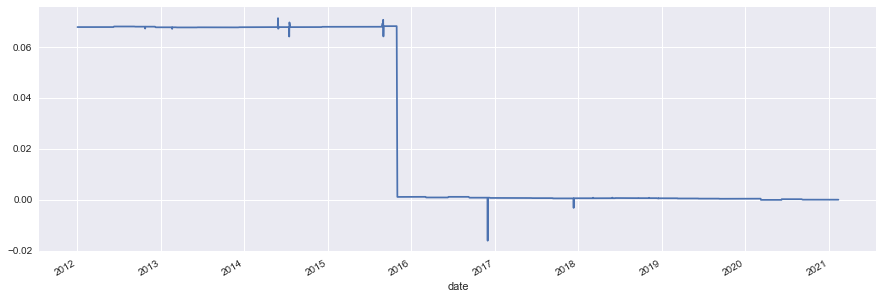

In [68]:
diff[('adj_open', 'HPQ')].plot()

<AxesSubplot:xlabel='date'>

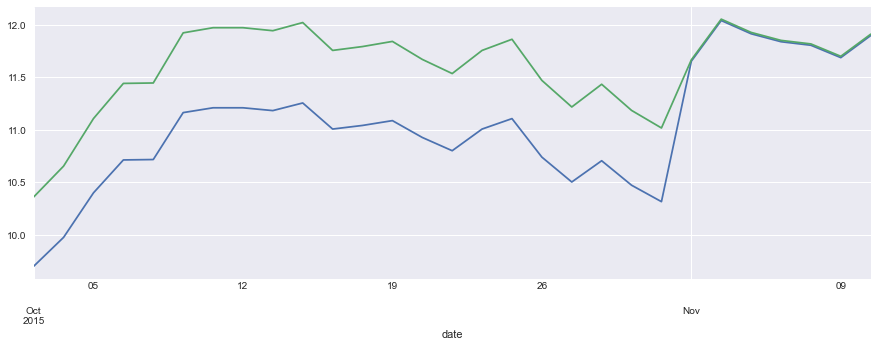

In [218]:
cp.loc['2015-10-01':'2015-11-10', ('adj_close', 'HPQ')].plot()
tiingo_prices.loc['2015-10-01':'2015-11-10', ('adj_close', 'HPQ')].plot()

In [142]:
fs[('adj_close', 'HPQ')]

date
2012-01-03     9.343610
2012-01-04     9.336591
2012-01-05     9.301493
2012-01-06     9.266394
2012-01-09     9.280432
                ...    
2021-02-08    27.300000
2021-02-09    27.090000
2021-02-10    27.150000
2021-02-11    27.380000
2021-02-12    27.490000
Name: (adj_close, HPQ), Length: 2294, dtype: float64

# SPWR

Pretty clearly a stock splits issue. I got into contact with the Tiingo support to verify this. Seems like they are likely in the wrong.

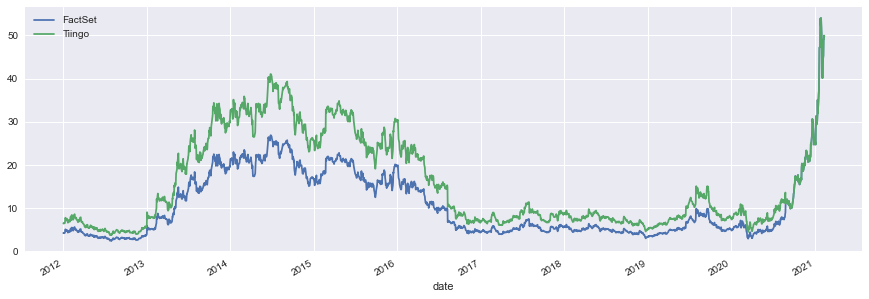

In [312]:
fs[('adj_close', 'SPWR')].plot(label='FactSet')
tiingo_prices[('adj_close', 'SPWR')].plot(label='Tiingo')
plt.legend()

<AxesSubplot:xlabel='date'>

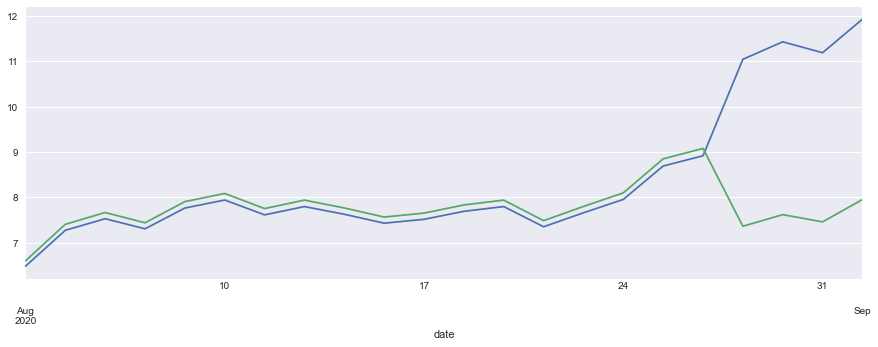

In [318]:
cp.loc['2020-08-03': '2020-09-01', ('adj_close', 'SPWR')].plot(label='FactSet')
(tiingo_prices.loc['2020-08-03': '2020-09-01', ('adj_close', 'SPWR')]* (2/3)).plot(label='tiingo')

In [283]:
tiingo_prices[('adj_close', 'SPWR')]['2014-08-19']

37.37

In [278]:
cp[('adj_close', 'SPWR')]

date
2012-01-03     4.216498
2012-01-04     4.314708
2012-01-05     4.281972
2012-01-06     4.249235
2012-01-09     4.262330
                ...    
2021-02-08    45.350000
2021-02-09    49.120000
2021-02-10    49.140000
2021-02-11    49.960000
2021-02-12    49.810000
Name: (adj_close, SPWR), Length: 2294, dtype: float64

In [279]:
tiingo_prices[('adj_close', 'SPWR')]

date
2012-01-03 00:00:00+00:00     6.44
2012-01-04 00:00:00+00:00     6.59
2012-01-05 00:00:00+00:00     6.54
2012-01-06 00:00:00+00:00     6.49
2012-01-09 00:00:00+00:00     6.51
                             ...  
2021-02-08 00:00:00+00:00    45.35
2021-02-09 00:00:00+00:00    49.12
2021-02-10 00:00:00+00:00    49.14
2021-02-11 00:00:00+00:00    49.96
2021-02-12 00:00:00+00:00    49.81
Name: (adj_close, SPWR), Length: 2294, dtype: float64

# ISRG

MI & Yahoo agree with FS

<AxesSubplot:xlabel='date'>

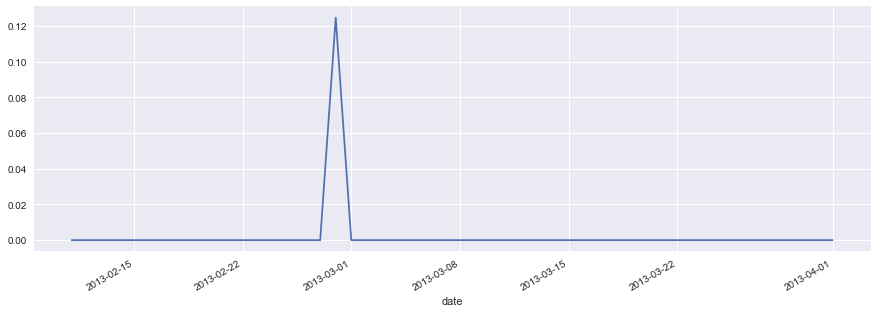

In [29]:
date_slice = slice('2013-02-10', '2013-04-01')
close_diff.loc[date_slice, 'ISRG'].plot()

<AxesSubplot:xlabel='date'>

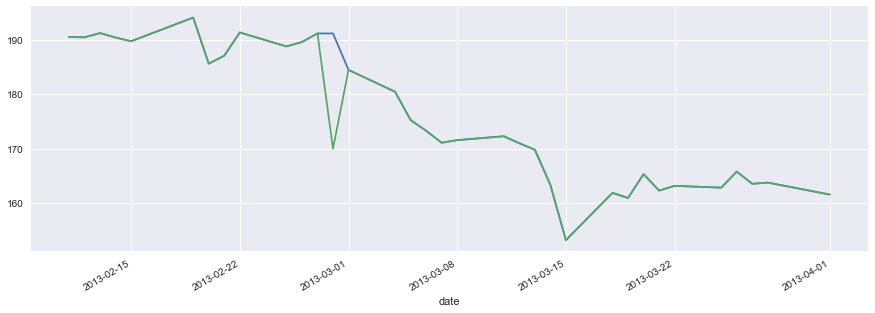

In [30]:
tiingo_prices.loc[date_slice, ('adj_close', 'ISRG')].plot()
fs.loc[date_slice, ('adj_close', 'ISRG')].plot()

In [36]:
print(tiingo_prices.loc['2013-02-26':'2013-03-02', ('adj_close', 'ISRG')])
print(fs.loc['2013-02-26':'2013-03-02', ('adj_close', 'ISRG')])

date
2013-02-26    189.586477
2013-02-27    191.173142
2013-02-28    191.173142
2013-03-01    184.466482
Name: (adj_close, ISRG), dtype: float64
date
2013-02-26    189.58667
2013-02-27    191.17334
2013-02-28    169.96335
2013-03-01    184.46667
Name: (adj_close, ISRG), dtype: float64


source: http://securities.stanford.edu/filings-documents/1050/ISRG00_02/2017126_r01c_13CV01920.pdf

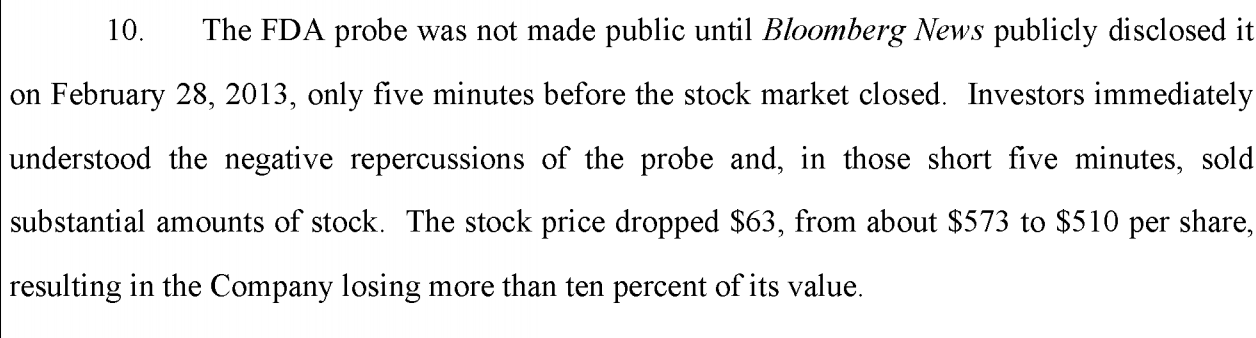

# NFLX

Huge spike in volume.

MI and Yahoo agree with FS.

<AxesSubplot:xlabel='date'>

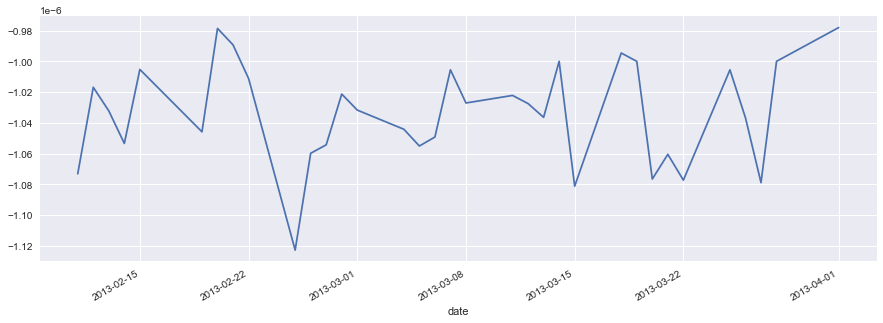

In [38]:
tick = 'NFLX'
date_slice = slice('2013-02-10', '2013-04-01')
close_diff.loc[date_slice, tick].plot()

<AxesSubplot:xlabel='date'>

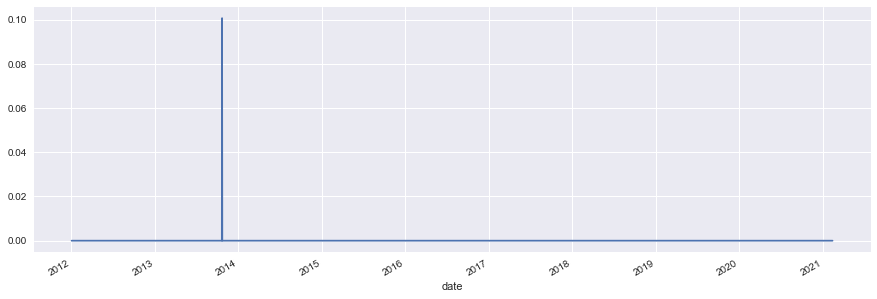

In [42]:
close_diff[tick].plot()

<AxesSubplot:xlabel='date'>

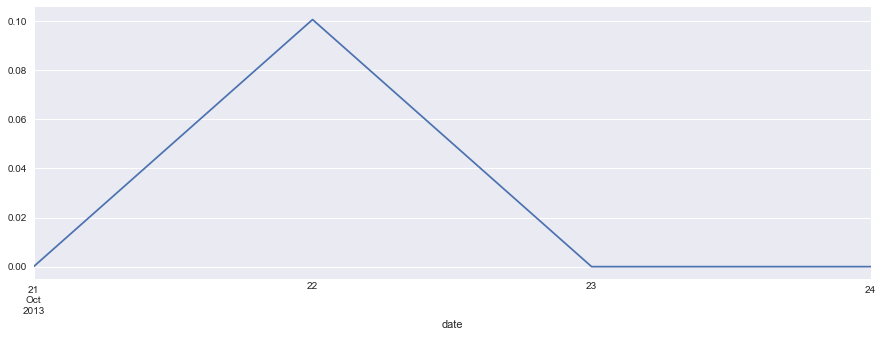

In [53]:
date_slice = slice('2013-10-20', '2013-10-24')
close_diff.loc[date_slice, tick].plot()

<AxesSubplot:xlabel='date'>

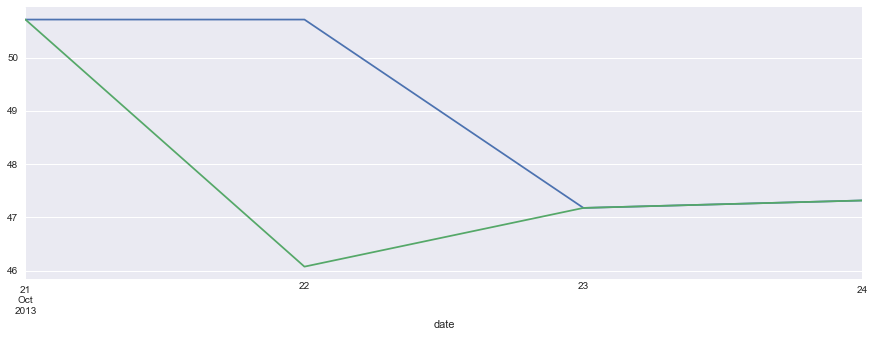

In [54]:
tiingo_prices.loc[date_slice, ('adj_close', tick)].plot()
fs.loc[date_slice, ('adj_close', tick)].plot()

FS matches Yahoo again.

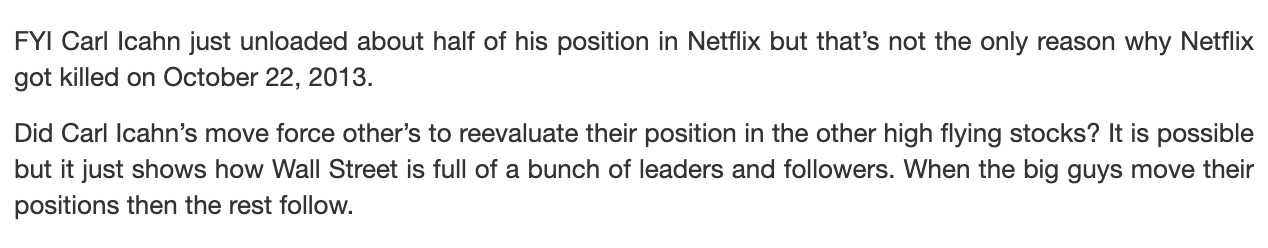

source: https://www.trefis.com/stock/ndaq/articles/212827/netflix-down-is-it-time-to-take-profits-on-momentum-stocks/2013-10-25

<AxesSubplot:xlabel='date'>

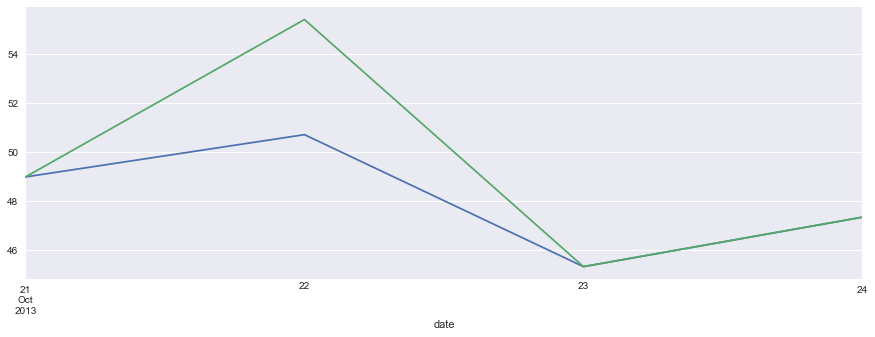

In [55]:
tiingo_prices.loc[date_slice, ('adj_open', tick)].plot()
fs.loc[date_slice, ('adj_open', tick)].plot()

# CRM

MI agrees with Tiingo; Yahoo with FS

<AxesSubplot:xlabel='date'>

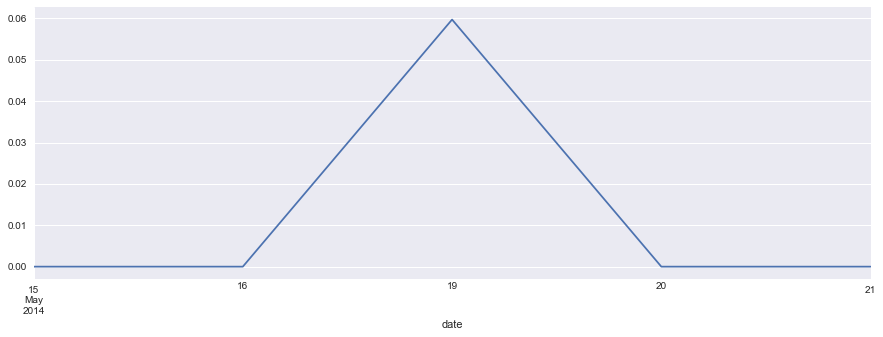

In [64]:
tick = 'CRM'
date_slice = slice('2014-05-15', '2014-05-21')
close_diff.loc[date_slice, tick].plot()
# close_diff[tick].plot()

<AxesSubplot:xlabel='date'>

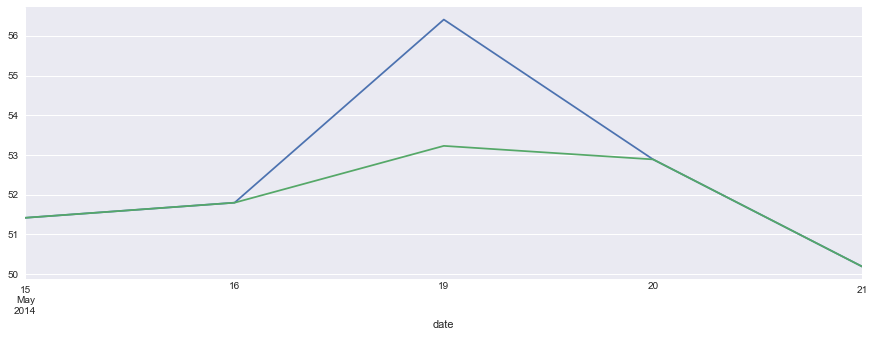

In [65]:
tiingo_prices.loc[date_slice, ('adj_close', tick)].plot()
fs.loc[date_slice, ('adj_close', tick)].plot()

Salesforce announced quarterly results after-hours.

# BIIB

<AxesSubplot:xlabel='date'>

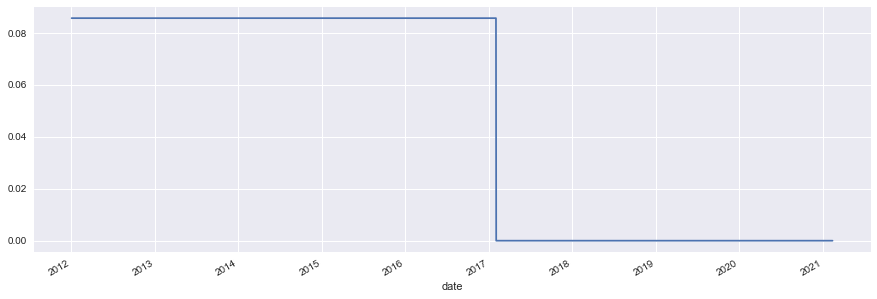

In [139]:
tick = 'BIIB'
# date_slice = slice('2017-01-20', '2017-02-05')
# close_diff.loc[date_slice, tick].plot()
close_diff[tick].plot()

<AxesSubplot:xlabel='date'>

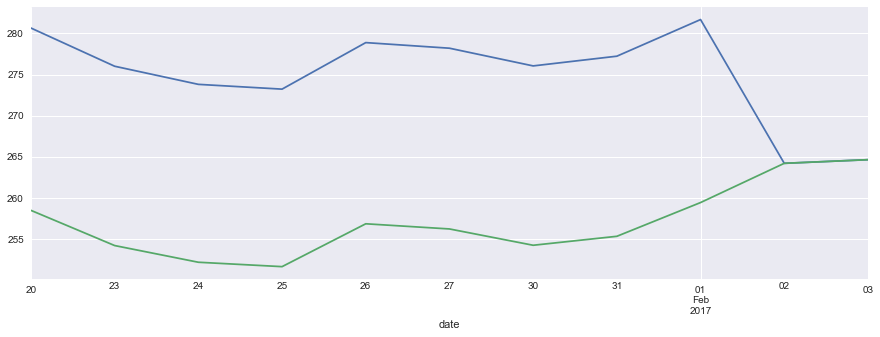

In [138]:
tiingo_prices.loc[date_slice, ('adj_close', tick)].plot()
fs.loc[date_slice, ('adj_close', tick)].plot()

In [ ]:
Biogen spin-off